# Алгоритмы анализа данных
## Курсовая работа. Классификация

Секция импорта в соответствии с правилами конкурса

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
np.set_printoptions(suppress=True)

Загружаем данные

In [2]:
train = pd.read_csv('expected-tutors/train.csv', sep=',')
train = np.transpose(train.values)
X = train[1:-1]  # id в процессе обучения нам не нужен
y = train[-1]

Делим на train и test выборки

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.transpose(X), np.transpose(y), test_size=0.2, random_state=1)

### Decision Tree Regressor

In [4]:
class Node:
    """Класс узла
    """
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
class Leaf:
    """Класс терминального узла (листа)
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        return np.mean(self.labels, axis=0)

In [7]:
def quality(left_labels, right_labels, current_gini):
    """Расчет качества
    """
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [8]:
def split(data, labels, index, t):
    """Разбиение датасета в узле
    """
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
def find_best_split(data, labels):
    """Нахождение наилучшего разбиения
    """
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
def build_tree(data, labels, max_depth=100):
    """Построение дерева с помощью рекурсивной функции
    """
    def build_tree_wrap(data, labels, max_depth, cur_depth):
        quality, t, index = find_best_split(data, labels)

        # Прекращаем рекурсию, когда нет прироста качества
        # или достигли лимита по глубине
        if quality == 0 or cur_depth >= max_depth:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree_wrap(true_data, true_labels, max_depth, cur_depth+1)
        false_branch = build_tree_wrap(false_data, false_labels, max_depth, cur_depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    return build_tree_wrap(data, labels, max_depth, 0)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(tree, data):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Проверим работу нашего дерева

In [13]:
def mean_squared_error(y_real, prediction):
    """Функция ошибки
    """
    return (sum((y_real - prediction)**2)) / len(y_real)

In [14]:
%%time
# Построим дерево по обучающей выборке
dr_tree = build_tree(X_train, y_train)
# Получим ответы для обучающей выборки 
train_answers = predict(dr_tree, X_train)
print('MSE на обучающей выборке:', mean_squared_error(y_train, train_answers))
# И получим ответы для тестовой выборки
test_answers = predict(dr_tree, X_test)
print('MSE на тестовой выборке:', mean_squared_error(y_test, test_answers))

MSE на обучающей выборке: 27.775400787754133
MSE на тестовой выборке: 49.10179606398851
CPU times: user 2.34 s, sys: 23.2 ms, total: 2.36 s
Wall time: 2.38 s


### Gradient Boosting Regressor

In [15]:
def gb_predict(X, trees_list, coef_list, eta):
    """Функция, реализующая предсказание в градиентном бустинге.
    """
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * coef * predict(alg, [x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [16]:
def bias(y, z):
    """L2 loss
    """
    return (y - z)

In [20]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """Функция обучения градиентного бустинга.
    """
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = None

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree = build_tree(X_train, y_train, max_depth=max_depth)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(X_train, bias(y_train, target), max_depth=max_depth)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Обучим модель и проверим её работу

In [18]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [19]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.2 на тренировочной выборке: 34.41503094577349
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.2 на тестовой выборке: 40.6854502676649


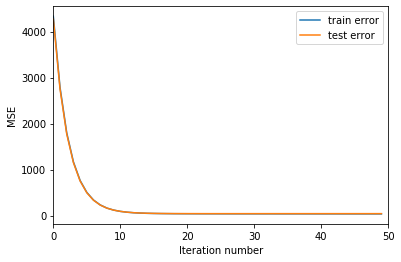

CPU times: user 1min 18s, sys: 754 ms, total: 1min 19s
Wall time: 1min 20s


In [51]:
%%time
n_trees = 50
max_depth = 5
eta = 0.2
coefs = [1] * n_trees
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors)

### Подготовим ответ для kaggle

In [52]:
test = pd.read_csv('expected-tutors/test.csv', sep=',')
test = np.transpose(test.values)
ids, test = test[0], test[1:]  # id для предсказания нам не нужен
test = np.transpose(test)

In [53]:
predicted = gb_predict(test, trees, coefs, eta)

In [57]:
predicted = predict(dr_tree, test)

In [58]:
result = np.array([ids, predicted])
result = np.transpose(result)

In [59]:
np.savetxt(
    'expected.csv', 
    result,
    fmt='%d,%f',
    delimiter=',', 
    header='Id,mean_exam_points', 
    comments='',
    encoding='utf-8',
)